In [2]:
import pandas as pd
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline
sns.set_style('white')


# 3.6.5 [Cancer Diagnostics](https://courses.thinkful.com/data-201v1/project/3.6.5)
Using set of [breast cancer data](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29), create a model to predict breast cancer. Also, what traits are most indicative of whether or not an individual will be diagnosed?



In [ ]:
2*a for a in x if a % 2 == 1]

In [1]:
df_reviews = pd.DataFrame(pd.read_csv('unit_3_data/creditcard.csv'))

NameError: name 'pd' is not defined

This problem is really a two stage question:
1. Predict if a flight is delayed (Classifier)
2. Predict how late (in minutes) a late flight will be (Regression)

The dataset provided includes cancelled flights which could be argued to be an extreme case of lateness or be deemed ineligible to be late since it will never arrive. For simiplicity I will remove cancelled flights.

### Hypothesis for amazon reviews:


### Cleaning Data
This is a pretty large dataset. It will help to quickly remove variables that are not adding information relevent to the model.
1. Cancellation information will not be necessary since we removed cancelled flights, there may be a pattern with specific planes but it is unlikely that the tail numbers or flight numbers are assigned in a way that reflects similar plane types or flight types. I will also remove year because I am only using data from 2008. Also there are a bunch of planned and actual times.  ['Cancelled', 'CancellationCode', 'TailNum', 'FlightNum', 'Year']
2. Since our focus is arrival delay and the dataset is sufficiently large I will remove flights where arrival delay is null.
3. To answer the first question 'predict if a flight is delayed' I will need to add a column that is a flag for instances where the delay is > 30minutes
4. By defining 'late' as 30 minutes past scheduled time lateness really begins at 30 minutes past. Therefore late time should be adjusted in relationship to this marker.
5. For flights that are delayed it may help to turn the delay type into a flag instead of a time


In [2]:
df_airline = pd.DataFrame(pd.read_csv('flight_delays.csv'))
df_airline = df_airline[df_airline['Cancelled']==0]

In [6]:
df_airline.shape

(6872294, 29)

In [3]:
# 1. Drop unnecessary columns
df_air = df_airline.drop(['Cancelled', 'CancellationCode', 'Diverted',
                          'TailNum', 'FlightNum', 'Year', 'DepTime', 'TaxiOut',
                          'TaxiIn', 'DepTime', 'ActualElapsedTime', 'ArrTime' ], axis=1)

# 2. Remove instances where arrival delay is null
df_air.dropna(axis=0, subset=['ArrDelay'], inplace=True)

# 3. Create flag delayed flight
df_air['delay_flag'] = np.where(df_air['ArrDelay']>=30, 1.0, 0.0)

# 4. Create late time feature that centers 0 at 30 minutes late
df_air['delay_time'] = df_air['ArrDelay']-30.0

# 5. Create flags for delay types to replace time delayed for the delay types
delay_type = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for delay in delay_type:
    df_air[delay] = np.where(df_air['delay_flag']==1.0, 
                             np.where(df_air[delay]>0.0, 1.0, 0.0), 0.0)


In [42]:
df_air.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,6855029.0,6.388525,3.398833,1.0,3.0,6.0,9.0,12.0
DayofMonth,6855029.0,15.738258,8.801086,1.0,8.0,16.0,23.0,31.0
DayOfWeek,6855029.0,3.925802,1.988459,1.0,2.0,4.0,6.0,7.0
DepTime,6855029.0,1333.775376,478.057380,1.0,928.0,1325.0,1728.0,2400.0
CRSDepTime,6855029.0,1325.037277,464.312948,0.0,925.0,1317.0,1715.0,2359.0
ArrTime,6855029.0,1481.265503,505.132207,1.0,1107.0,1512.0,1909.0,2400.0
CRSArrTime,6855029.0,1493.714708,482.664194,0.0,1115.0,1515.0,1905.0,2359.0
ActualElapsedTime,6855029.0,127.322424,70.187308,12.0,77.0,110.0,157.0,1379.0
CRSElapsedTime,6855029.0,129.077814,69.532711,-141.0,80.0,111.0,159.0,660.0
AirTime,6855029.0,104.018589,67.439796,0.0,55.0,86.0,132.0,1350.0


Taking a look at our target variables delay flag and delay time we see that about 13.5% of flights that are not cancelled are delayed. Planes that Arrive 'on time' actually arrive 4 minutes before the scheduled arrival time on average. Late planes are a total of 59 minutes late typically.

In [15]:
df_air.groupby('delay_flag').describe()['delay_time'].round().T

delay_flag,0.0,1.0
count,5927614.0,927415.0
mean,-33.0,50.0
std,13.0,63.0
min,-549.0,0.0
25%,-41.0,11.0
50%,-34.0,29.0
75%,-26.0,66.0
max,-1.0,2431.0


In [16]:
df_air['delay_flag'].mean()

0.1352897267101277

In [6]:
df_air = df_air[['delay_flag', 'delay_time', 'Origin', 'Dest', 'Distance', 'AirTime', 
                 'CRSDepTime', 'Month', 'DayOfWeek' , 'CarrierDelay', 'DepDelay', 'WeatherDelay', 
                 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

In [7]:
def day_of_week(x):
    if x == 1:
        return "monday"
    elif x==2:
        return "tuesday"
    elif x==3:
        return "wednesday"
    elif x==4:
        return "thursday"
    elif x==5:
        return "friday"
    elif x==6:
        return "saturday"
    elif x==7:
        return "sunday"
df_air['DayOfWeek'] = df_air['DayOfWeek'].apply(lambda x: day_of_week(x))    

### The size of this dataset is unweidley so I'm going to sample

In [9]:
# Random Sample
df_air = df_air.sample(n=200000, random_state=42, replace=False)


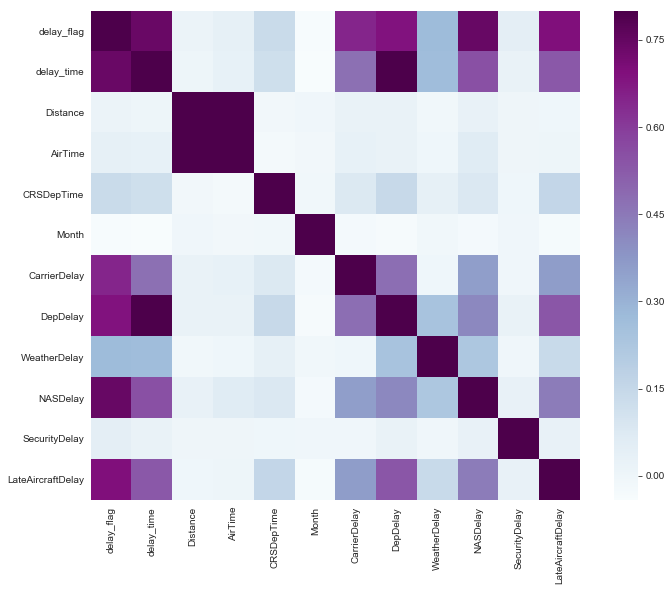

In [35]:
# Make the correlation matrix.
corrmat = df_air_sample.corr()
#print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap='BuPu')
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.



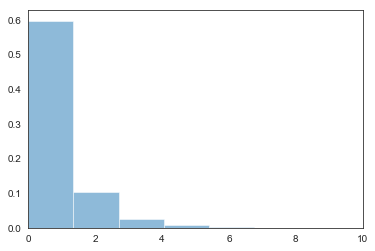

In [46]:
plt.hist(df_air[df_air['delay_flag']==1.0]['delay_time']/60.0, bins=30, label='delayed', alpha=0.5, density=True)
plt.xlim(0,10)

plt.title('Histogram of flight time delay in hours')
plt.show()

In [48]:
df_air.columns
continuous = ['delay_time', 'Distance', 'AirTime', 'CRSDepTime', 'Month', 'DepDelay']

In [49]:
df_air[continuous]

,delay_time,Distance,AirTime,CRSDepTime,Month,DepDelay
0,-44.0,810,116.0,1955,1,8.0
1,-28.0,810,113.0,735,1,19.0
2,-16.0,515,76.0,620,1,8.0
3,-36.0,515,78.0,930,1,-4.0
4,4.0,515,77.0,1755,1,34.0
5,-19.0,688,87.0,1915,1,25.0
6,27.0,1591,230.0,1830,1,67.0
7,-48.0,1591,219.0,1040,1,-1.0
8,-28.0,451,70.0,615,1,2.0
9,-46.0,451,70.0,1620,1,0.0


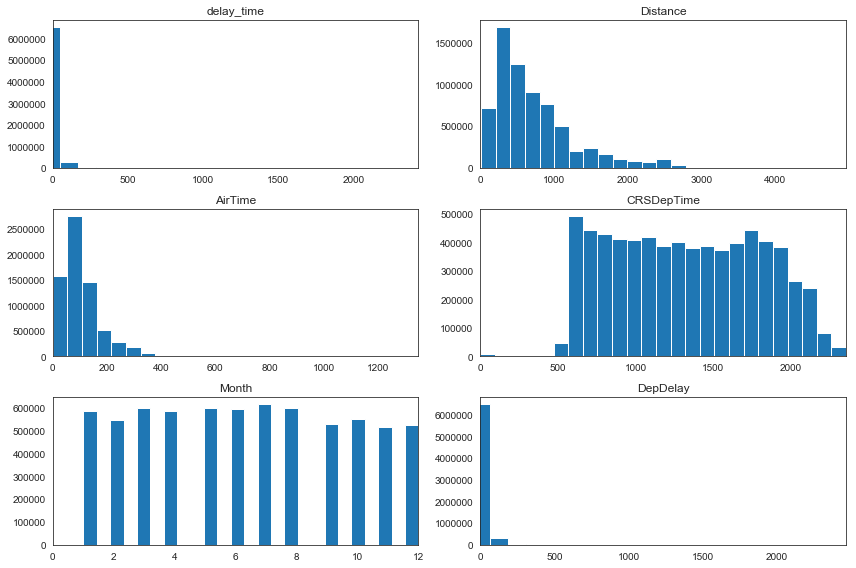

In [51]:
plt.figure(figsize=(12,8))
n = 0

for x in continuous:    
    n=n+1
    plt.subplot(3,2,n)
    plt.hist(df_air[x], bins=25)
    plt.xlim(0,df_air[x].max())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.title(x)
plt.tight_layout()
plt.show()

(-100, 1500)

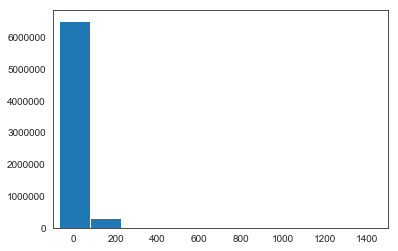

In [29]:
plt.hist(df_air.ArrDelay, bins=20)
plt.xlim(-100, 1500)

### Ideally the airport pairings would all be used but with time and computation restrictions helpful to cut down to the biggest offenders

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
X = df_air.drop(['delay_flag', 'delay_time','Dest','Origin'], axis=1)
X = pd.get_dummies(X)
y = df_air['delay_flag']

In [5]:
# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Build our model.
# Instantiate knn & knn weighted models
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')


In [ ]:
score = cross_val_score(knn, X_scaled, y, cv=3)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
